In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [ ]:
# === Step 1: Start with your DataFrame ===
data = np.load('numpy_combined/structured_data.npy', allow_pickle=True)
df = pd.DataFrame(data)

# Step 2: Sort hole cards so that order doesn’t matter
df["low_card"] = df[["hole_card_1_rank", "hole_card_2_rank"]].min(axis=1)
df["high_card"] = df[["hole_card_1_rank", "hole_card_2_rank"]].max(axis=1)

# Step 3: Convert boolean features to integers
df["is_suited"] = df["is_suited"].astype(int)
df["is_pair"] = df["is_pair"].astype(int)

# === Step 4: Define features and target ===
categorical_features = ["position", "low_card", "high_card"]
numeric_features = ["is_suited", "is_pair", "card_gap"]
target = "net_gain_bb"

X = df[categorical_features + numeric_features]
y = df[target]

# === Step 5: Preprocessing pipeline ===
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ]
)

# === Step 6: Full pipeline with linear regression ===
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# === Step 7: Train-test split and train the model ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

# === Step 8: Evaluate ===
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
y_const = y_test * 0.00000001 + y_train.mean()
mae_const = mean_absolute_error(y_test, y_const)
print(f"Mean absolute error on test set: {mae}")
print(f"Mean absolute error of constant predictions: {mae_const}")
print(f"R² score on test set: {r2:.4f}")


Mean absolute error on test set: 2.503463626289601
Mean absolute error of constant predictions: 0.38256948877279245
R² score on test set: 0.0036


In [8]:
# Get feature names from OneHotEncoder
ohe = model.named_steps["preprocessor"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Numeric feature names (they remain unchanged)
num_feature_names = numeric_features

# Combine all
feature_names = list(ohe_feature_names) + num_feature_names

# Get coefficients from the linear regression model
coefficients = model.named_steps["regressor"].coef_


# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
}).sort_values("coefficient", key=abs, ascending=False)


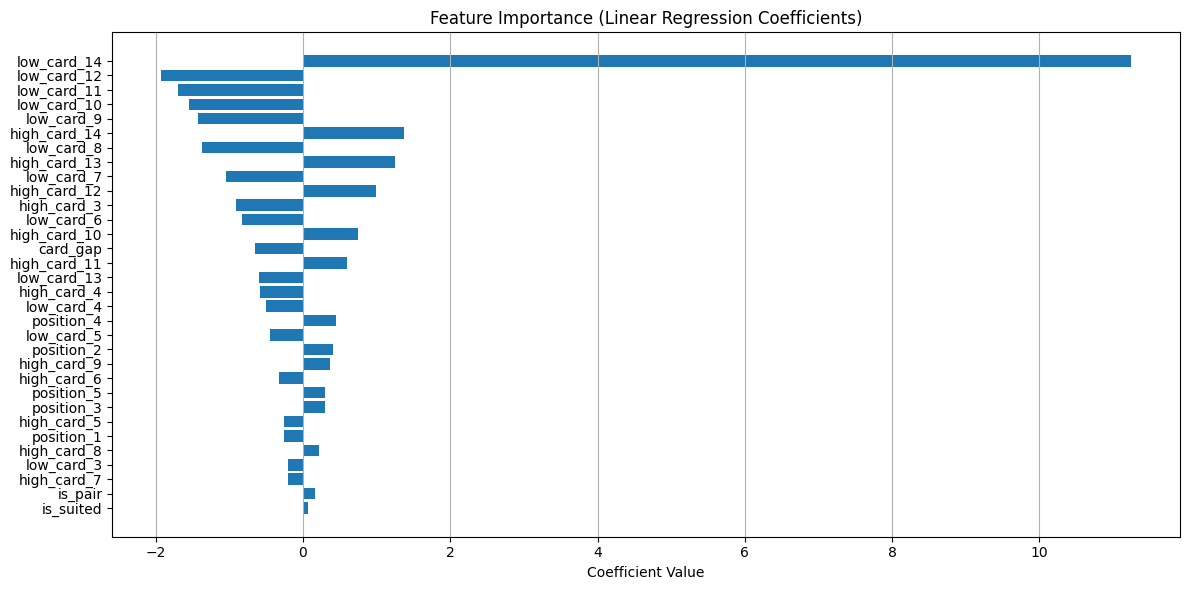

In [10]:
plt.figure(figsize=(12, 6))
plt.barh(coef_df["feature"], coef_df["coefficient"])
plt.xlabel("Coefficient Value")
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.gca().invert_yaxis()  # Most important at the top
plt.grid(axis='x')
plt.tight_layout()
plt.show()
